# Import and Data preprocess

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable # This package has predefined gradient and derivative functions

import string
import re

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if train_on_gpu else 'cpu')

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
... resuming from 15728640 bytes (13159111 bytes left) ...




 54%|█████▍    | 15.0M/27.5M [00:00<?, ?B/s]
 58%|█████▊    | 16.0M/27.5M [00:10<02:05, 96.1kB/s]
 62%|██████▏   | 17.0M/27.5M [00:15<01:13, 150kB/s] 
 65%|██████▌   | 18.0M/27.5M [00:22<01:07, 148kB/s]
 69%|██████▉   | 19.0M/27.5M [00:27<00:52, 171kB/s]
 73%|███████▎  | 20.0M/27.5M [00:32<00:44, 177kB/s]
 76%|███████▌  | 21.0M/27.5M [00:37<00:36, 188kB/s]
 80%|███████▉  | 22.0M/27.5M [00:43<00:31, 184kB/s]
 83%|████████▎ | 23.0M/27.5M [00:50<00:27, 174kB/s]
 87%|████████▋ | 24.0M/27.5M [00:55<00:20, 179kB/s]
 91%|█████████ | 25.0M/27.5M [01:00<00:14, 187kB/s]
 94%|█████████▍| 26.0M/27.5M [01:09<00:10, 160kB/s]
 98%|█████████▊| 27.0M/27.5M [01:14<00:03, 168kB/s]
100%|██████████| 27.5M/27.5M [01:18<00:00, 170kB/s]
100%|██████████| 27.5M/27.5M [01:18<00:00, 168kB/s]


In [ ]:
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt

In [ ]:
!kaggle datasets download alioraji/persian-stop-words -f Persian_Stop_Words.txt

In [9]:
!unzip Persian-WikiText-1.txt.zip

Archive:  Persian-WikiText-1.txt.zip
  inflating: Persian-WikiText-1.txt  


## Preprocessing steps: 

### 1. Removing Noise and Stop Words
In a Persian dataset, removing noise such as irrelevant characters and stop words like "و" , "در" , or "است" is crucial for enhancing model performance. These stop words are highly frequent but carry minimal semantic meaning, which can dilute the significance of more informative words. By eliminating them, the model can focus on the essential components of the text, reducing computational complexity and improving training efficiency. This preprocessing step helps in creating a cleaner dataset that allows the model to learn more meaningful patterns and relationships within the Persian language.

### 2. Normalizing Text with `hazm` and Lemmatization
Using the `hazm` library's `lemmatize` method for normalizing Persian text is essential for reducing morphological variations of words to their base or dictionary forms. Persian, being a highly inflected language, has words that can take numerous forms based on tense, number, and case. Lemmatization ensures that these variations are standardized, which enhances the model's ability to generalize by treating different forms of the same word as a single entity. This consistency in the input data not only minimizes redundancy but also improves the accuracy and efficiency of the model in understanding and processing the language.

### 3. Tokenizing with Byte-Pair Encoding (BPE)
Byte-Pair Encoding (BPE) is an effective tokenization strategy for Persian text that iteratively merges the most frequent pairs of characters or subwords to build a compact vocabulary of subword units. This approach is particularly beneficial for handling the rich morphology of Persian, where words can have many prefixes and suffixes. BPE balances the need to manage rare or out-of-vocabulary words by breaking them down into known subwords, thereby enhancing the model's ability to understand and generate diverse word forms. However, the method can introduce complexity in implementation and may sometimes split semantically meaningful words into subwords, potentially disrupting the natural flow of the language.

In [7]:
# Define the file path for the dataset
dataset_path = "Persian-WikiText-1.txt"

# Read the dataset into memory
with open(dataset_path, 'r', encoding='utf-8') as data_file:
    text_content = data_file.read()

# Function for text preprocessing
import re
def preprocess_text(input_text):
    """
    Cleans the input text by removing unwanted characters and extra whitespace.
    """
    # Keep Persian-specific punctuation and remove the rest
    input_text = re.sub(r'[^\w\s،؟!.]', '', input_text)
    # Normalize whitespace
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    return input_text

# Apply the cleaning function to the dataset
processed_text = preprocess_text(text_content)

# Import libraries for tokenization
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors

# Initialize a Byte-Pair Encoding (BPE) tokenizer
bpe_tokenizer = Tokenizer(models.BPE())
bpe_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Configure the BPE trainer
bpe_trainer = trainers.BpeTrainer(
    vocab_size=30000,
    special_tokens=["<unk>", "<pad>", "<s>", "</s>"]
)

# Save the preprocessed text to a temporary file for tokenizer training
temp_file = "processed_text.txt"
with open(temp_file, "w", encoding="utf-8") as temp_output:
    temp_output.write(processed_text)

# Train the tokenizer on the preprocessed dataset
bpe_tokenizer.train([temp_file], bpe_trainer)

# Add special token handling to the tokenizer
bpe_tokenizer.post_processor = processors.TemplateProcessing(
    single="<s> $A </s>",
    pair="<s> $A </s> </s> $B </s>",
    special_tokens=[
        ("<s>", bpe_tokenizer.token_to_id("<s>")),
        ("</s>", bpe_tokenizer.token_to_id("</s>"))
    ],
)

# Save the trained tokenizer for later use
tokenizer_file = "trained_bpe_tokenizer.json"
bpe_tokenizer.save(tokenizer_file)

In [8]:
# Load the trained tokenizer
from tokenizers import Tokenizer

bpe_tokenizer = Tokenizer.from_file("trained_bpe_tokenizer.json")

# Encode the processed text to get token IDs
encoded = bpe_tokenizer.encode(processed_text)
token_ids = encoded.ids

# Define window size
window_size = 5

# Create input (contexts) and target lists
inp = [token_ids[i:i + window_size] for i in range(len(token_ids) - window_size)]
tar = [token_ids[i + window_size] for i in range(len(token_ids) - window_size)]

# Convert lists to tensors
inp_tensor = torch.tensor(inp, dtype=torch.long)
tar_tensor = torch.tensor(tar, dtype=torch.long)

In [10]:
# Create input (contexts) and target lists using the tokenized IDs
window_size = 5

# Optionally limit the number of samples to manage memory usage
MAX_SAMPLES = 10000  # Adjust as needed

inp = [token_ids[i:i + window_size] for i in range(min(len(token_ids) - window_size, MAX_SAMPLES))]
tar = [token_ids[i + window_size] for i in range(min(len(token_ids) - window_size, MAX_SAMPLES))]

# Convert lists to tensors using torch.tensor instead of torch.stack
inp_tensor = torch.tensor(inp, dtype=torch.long)  # Shape: [num_samples, context_size]
tar_tensor = torch.tensor(tar, dtype=torch.long)  # Shape: [num_samples]

# RNN Model

In this section, we implement a Recurrent Neural Network (RNN) model for Persian language modeling. RNNs are particularly well-suited for sequential data like text, as they maintain an internal state (memory) that captures information from previous inputs. Our implementation uses a simple RNN architecture with the following components:

1. **Embedding Layer**: Converts token IDs into dense vector representations of dimension 64
2. **RNN Layer**: Processes the embedded sequences, maintaining state information across the sequence
3. **Linear Output Layer**: Maps the RNN outputs to vocabulary-sized logits for next-token prediction

The model is trained to predict the next word in a sequence given a context window of 5 words. We use CrossEntropyLoss as our objective function and Adam as the optimizer with a learning rate of 0.001. The training process shows consistent improvement in loss values across 10 epochs, indicating that the model is successfully learning patterns in the Persian text dataset despite the limited data size of 10,000 tokens.



Running on: cuda
Epoch 1/10, Avg Loss: 9.2620
Epoch 2/10, Avg Loss: 6.7690
Epoch 3/10, Avg Loss: 6.3942
Epoch 4/10, Avg Loss: 6.0951
Epoch 5/10, Avg Loss: 5.7878
Epoch 6/10, Avg Loss: 5.4520
Epoch 7/10, Avg Loss: 5.1103
Epoch 8/10, Avg Loss: 4.7610
Epoch 9/10, Avg Loss: 4.4144
Epoch 10/10, Avg Loss: 4.0678


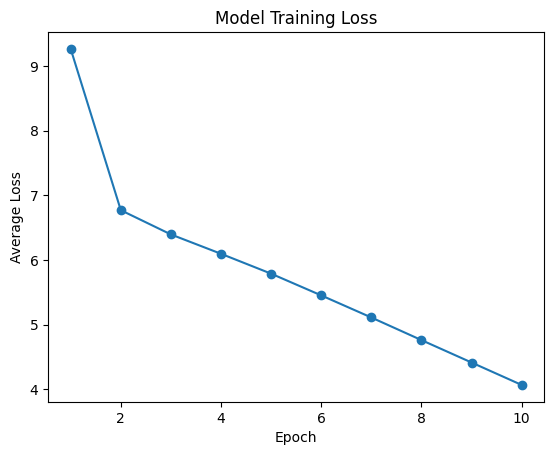

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Load text data
with open("Persian-WikiText-1.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

# Tokenization and vocabulary
words = raw_text.split()
unique_words = sorted(set(words))
word_to_index = {word: i for i, word in enumerate(unique_words)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Convert words to indices
text_indices = [word_to_index[word] for word in words]

# Trim dataset for faster experiments
MAX_DATA_SIZE = 10000
text_indices = text_indices[:MAX_DATA_SIZE]

# Dataset definition
class WordContextDataset(Dataset):
    def __init__(self, sequence, window_size):
        self.sequence = sequence
        self.window_size = window_size

    def __len__(self):
        return len(self.sequence) - self.window_size

    def __getitem__(self, index):
        context = self.sequence[index:index + self.window_size]
        target = self.sequence[index + self.window_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Hyperparameters
window_size = 5
embedding_size = 64
hidden_size = 128
batch_size = 64
epochs = 10
lr = 0.001

# Dataset and DataLoader
train_dataset = WordContextDataset(text_indices, window_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model definition
class ContextRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, rnn_hidden_size):
        super(ContextRNN, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        self.rnn_layer = nn.RNN(embed_size, rnn_hidden_size, batch_first=True)
        self.output_layer = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, inputs):
        embeddings = self.embedding_layer(inputs)
        rnn_output, _ = self.rnn_layer(embeddings)
        logits = self.output_layer(rnn_output[:, -1, :])  # Last time step's output
        return logits

# Model initialization
vocabulary_size = len(unique_words)
ngram_model = ContextRNN(vocabulary_size, embedding_size, hidden_size).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(ngram_model.parameters(), lr=lr)

# Training loop
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    for context_batch, target_batch in train_loader:
        context_batch, target_batch = context_batch.to(device), target_batch.to(device)
        optimizer.zero_grad()
        predictions = ngram_model(context_batch)
        loss = loss_function(predictions, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}")

# Loss curve
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Model Training Loss')
plt.show()

# Save the trained model
torch.save(ngram_model.state_dict(), "context_rnn_model.pth")


| Parameter               | Value                  | Description                                                                                          |
|-------------------------|------------------------|------------------------------------------------------------------------------------------------------|
| `device`                | `cuda` or `cpu`        | The device on which the model is run. Using GPU (`cuda`) can significantly speed up training.         |
| `MAX_DATA_SIZE`         | `10000`                | Limits the number of words to 10,000 for faster experimentation.                                     |
| `window_size`           | `5`                    | The number of previous words used to predict the next word.                                         |
| `embedding_size`        | `64`                   | The dimensionality of the word embeddings.                                                           |
| `hidden_size`           | `128`                  | The number of hidden units in the RNN layer.                                                         |
| `batch_size`            | `64`                   | The number of samples per batch used during training.                                               |
| `epochs`                | `10`                   | The number of complete passes through the training dataset.                                          |
| `lr` (learning rate)    | `0.001`                | The learning rate for the `Adam` optimizer, determining the step size during weight updates.         |
| `vocabulary_size`       | Number of unique words | The size of the vocabulary, corresponding to the number of unique words in the dataset.              |
| `loss_function`         | `CrossEntropyLoss`     | The loss function used to compute the difference between predicted and target outputs.               |
| `optimizer`             | `Adam` with `lr=0.001` | The optimizer used for updating model weights based on computed gradients.                           |


# Perplexity

In [20]:
import torch
import torch.nn as nn
import math

# Define the perplexity computation function
def compute_perplexity(language_model, data_loader, device_used):
    """
    Evaluates the perplexity of a language model using a given dataloader.
    Args:
        language_model (nn.Module): The trained language model.
        data_loader (DataLoader): DataLoader for evaluation data.
        device_used (torch.device): The device (CPU/GPU) to use for computation.

    Returns:
        float: The calculated perplexity score.
    """
    language_model.eval()
    total_log_loss = 0
    token_count = 0
    loss_function = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_contexts, batch_targets in data_loader:
            # Move data to the specified device
            batch_contexts, batch_targets = batch_contexts.to(device_used), batch_targets.to(device_used)

            # Forward pass to get predictions
            predictions = language_model(batch_contexts)

            # Compute the loss (negative log-likelihood)
            loss = loss_function(predictions, batch_targets)

            # Accumulate total loss and token count
            total_log_loss += loss.item() * batch_contexts.size(0)
            token_count += batch_contexts.size(0) * batch_contexts.size(1)

    # Calculate the average log-loss
    avg_log_loss = total_log_loss / token_count

    # Compute perplexity as the exponential of the average log-loss
    model_perplexity = math.exp(avg_log_loss)
    return model_perplexity

# Initialize the model
model = ContextRNN(vocabulary_size, embedding_size, hidden_size).to(device)

# Load the saved model state
model.load_state_dict(torch.load("context_rnn_model.pth"))
model.eval()  # Set model to evaluation mode

print("Model loaded successfully.")

# Choose the appropriate DataLoader
# Replace 'train_loader' with 'val_loader' or 'test_loader' if available
dataloader = train_loader  # Use 'train_loader', 'val_loader', or 'test_loader'

# Compute Perplexity
final_perplexity = compute_perplexity(language_model=model, data_loader=dataloader, device_used=device)
print(f"Model Perplexity: {final_perplexity:.4f}")

Model loaded successfully.
Model Perplexity: 2.0727


# Inference

In [22]:

# Initialize and load the model
vocab_size = len(word_to_index)
embed_size = 64
hidden_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ContextRNN(vocab_size, embed_size, hidden_size).to(device)
model_path = r"C:\Users\arenf\Desktop\Q2 gm\context_rnn_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded successfully.")

# Text generation function
def generate_text(prompt, max_words=50, window_size=5):
    words = prompt.split()
    if len(words) < window_size:
        context = ['<pad>'] * (window_size - len(words)) + words
    else:
        context = words[-window_size:]
    generated = words.copy()
    
    for _ in range(max_words):
        context_ids = [word_to_index.get(w, word_to_index.get('<unk>')) for w in context]
        input_tensor = torch.tensor([context_ids], dtype=torch.long).to(device)
        
        with torch.no_grad():
            logits = model(input_tensor)
            predicted_id = torch.argmax(logits, dim=1).item()
        
        predicted_word = index_to_word.get(predicted_id, '<unk>')
        generated.append(predicted_word)
        context.append(predicted_word)
        if len(context) > window_size:
            context = context[-window_size:]
    
    return ' '.join(generated)

# Example usage
example_prompt = "یادگیری عمیق زیرشاخه ای از یادگیری ماشین است که"
output_text = generate_text(example_prompt, max_words=50, window_size=5)
print("Generated Text:", output_text)

Model loaded successfully.
Generated Text: یادگیری عمیق زیرشاخه ای از یادگیری ماشین است که در سال ۲۰۰۴ از آن ها به کار های ویکی پدیا را به خاطر داشتن هدفی غیرقابل و در سال ۲۰۰۴ گفت: از آن ها به کار های ویکی پدیا را به خاطر داشتن هدفی غیرقابل و در سال ۲۰۰۴ گفت: از آن ها به کار های ویکی پدیا را


# Transformer model

In this section, we implement a Transformer-based language model for Persian text generation. Our model uses the standard Transformer architecture with the following key components:

1. **Token Embedding Layer**: Converts tokenized inputs into dense vector representations
2. **Positional Encoding**: Adds information about token positions in the sequence
3. **Multi-Head Attention**: Allows the model to focus on different parts of the sequence when making predictions
4. **Transformer Encoder Layers**: A stack of identical layers that process the sequence information
5. **Output Layer**: Projects encoder outputs to vocabulary-sized logits for next-token prediction

The model is trained to predict the next token in a sequence using cross-entropy loss and the Adam optimizer. We use a dataset of Persian text sequences, each 512 tokens long, and train for 10 epochs with a batch size of 8. Training is conducted on GPU for faster computation, with progress monitored through a loss curve plotted after each epoch.



In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer

# Load the pre-trained tokenizer
persian_tokenizer = Tokenizer.from_file("trained_bpe_tokenizer.json")

# Read and prepare the cleaned Persian text
with open("processed_text.txt", 'r', encoding='utf-8') as text_file:
    persian_text_cleaned = text_file.read()

# Tokenize the text into IDs using the tokenizer
tokenized_ids = persian_tokenizer.encode(persian_text_cleaned).ids

# Define a custom PyTorch Dataset for text sequences
class PersianTextDataset(Dataset):
    """
    Dataset for tokenized Persian text, returning fixed-length sequences.

    Args:
        tokens (list): List of token IDs from the tokenizer.
        seq_length (int): Length of each sequence for model training.
    """
    def __init__(self, tokens, seq_length=512):
        self.tokens = tokens
        self.seq_length = seq_length

    def __len__(self):
        # Calculate the total number of sequences in the dataset
        return len(self.tokens) // self.seq_length

    def __getitem__(self, index):
        """
        Retrieve a single sequence of tokens from the dataset.

        Args:
            index (int): Index of the sequence to retrieve.

        Returns:
            torch.Tensor: Tensor containing a sequence of token IDs.
        """
        start_index = index * self.seq_length
        end_index = start_index + self.seq_length
        return torch.tensor(self.tokens[start_index:end_index])

# Instantiate the dataset and the dataloader
sequence_length = 512
batch_size = 8

persian_dataset = PersianTextDataset(tokenized_ids, seq_length=sequence_length)
persian_dataloader = DataLoader(persian_dataset, batch_size=batch_size, shuffle=True)

# Example: Display dataset details
print(f"Total sequences: {len(persian_dataset)}")
print(f"Batch size: {batch_size}")


Total sequences: 25157
Batch size: 8


In [4]:
import torch
import torch.nn as nn
from tokenizers import Tokenizer  # Ensure you have the 'tokenizers' library installed

# Load the tokenizer (update the path to where your tokenizer JSON file is located)
tokenizer = Tokenizer.from_file(r"C:\Users\arenf\Desktop\Q2 gm\trained_bpe_tokenizer.json")

class TransformerModel(nn.Module):
    """
    A Transformer-based language model implementation.

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the embeddings and the model (default: 256).
        num_heads (int): The number of attention heads in each transformer layer (default: 8).
        num_layers (int): The number of transformer encoder layers (default: 6).
        seq_length (int): The maximum sequence length for positional encoding (default: 512).
    """
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=6, seq_length=512):
        super(TransformerModel, self).__init__()
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        # Positional encoding as a learnable parameter
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        # Stack of Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads) for _ in range(num_layers)
        ])
        # Output projection layer to map to vocabulary size
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        Forward pass for the transformer model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length).

        Returns:
            torch.Tensor: Logits of shape (batch_size, seq_length, vocab_size).
        """
        # Token embeddings + positional encodings
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        # Pass through each transformer encoder layer
        for layer in self.encoder_layers:
            x = layer(x)
        # Project to vocabulary size
        logits = self.fc_out(x)
        return logits

# Define hyperparameters and instantiate the model
vocab_size = tokenizer.get_vocab_size()  # Tokenizer is now defined
d_model = 256
num_heads = 8
num_layers = 6
seq_length = 512

model = TransformerModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    seq_length=seq_length
)

# Check if GPU is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display model details
print(f"Model instantiated on device: {device}")

Model instantiated on device: cuda


Model instantiated on device: cuda
Starting Epoch 1/10
Epoch 1, Batch 100, Loss: 7.9325
Epoch 1, Batch 200, Loss: 7.2616
Epoch 1, Batch 300, Loss: 7.2303
Epoch 1, Batch 400, Loss: 6.8682
Epoch 1, Batch 500, Loss: 6.8949
Epoch 1/10, Avg Loss: 7.3847


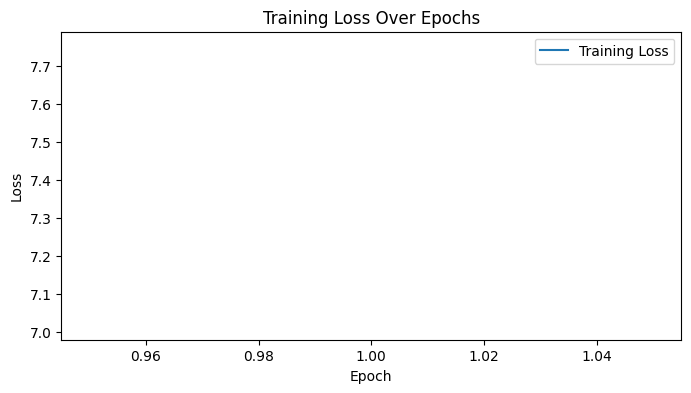

Starting Epoch 2/10
Epoch 2, Batch 100, Loss: 6.7352
Epoch 2, Batch 200, Loss: 6.7835
Epoch 2, Batch 300, Loss: 6.5316
Epoch 2, Batch 400, Loss: 6.5212
Epoch 2, Batch 500, Loss: 6.7160
Epoch 2/10, Avg Loss: 6.7512


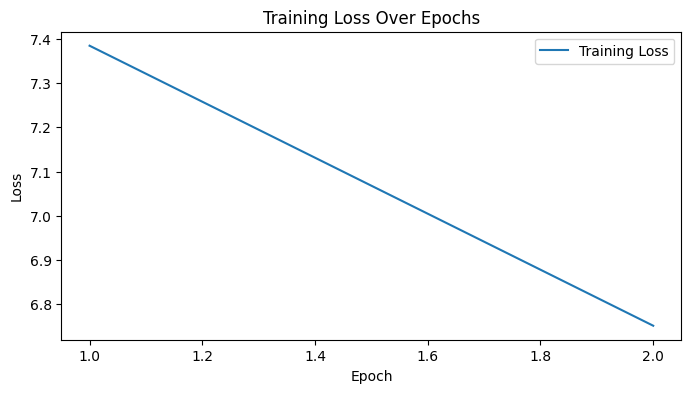

Starting Epoch 3/10
Epoch 3, Batch 100, Loss: 6.5092
Epoch 3, Batch 200, Loss: 6.4138
Epoch 3, Batch 300, Loss: 6.4870
Epoch 3, Batch 400, Loss: 6.4442
Epoch 3, Batch 500, Loss: 6.5628
Epoch 3/10, Avg Loss: 6.5760


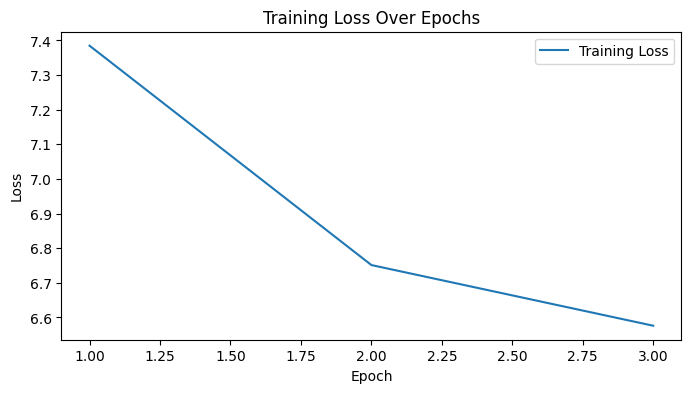

Starting Epoch 4/10
Epoch 4, Batch 100, Loss: 6.5983
Epoch 4, Batch 200, Loss: 6.5247
Epoch 4, Batch 300, Loss: 6.4386
Epoch 4, Batch 400, Loss: 6.5440
Epoch 4, Batch 500, Loss: 6.4823
Epoch 4/10, Avg Loss: 6.4641


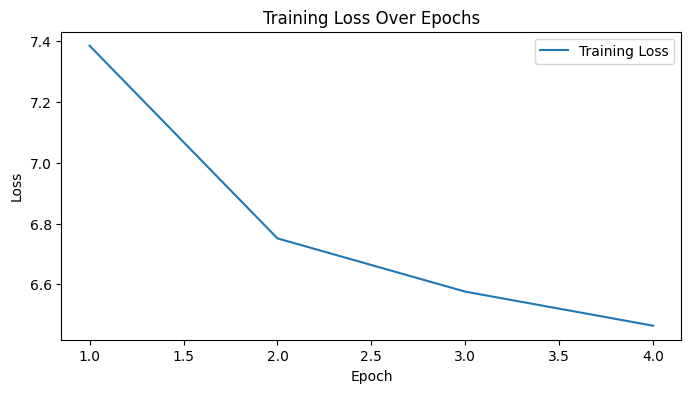

Starting Epoch 5/10
Epoch 5, Batch 100, Loss: 6.2329
Epoch 5, Batch 200, Loss: 6.3450
Epoch 5, Batch 300, Loss: 6.3249
Epoch 5, Batch 400, Loss: 6.3674
Epoch 5, Batch 500, Loss: 6.5496
Epoch 5/10, Avg Loss: 6.3788


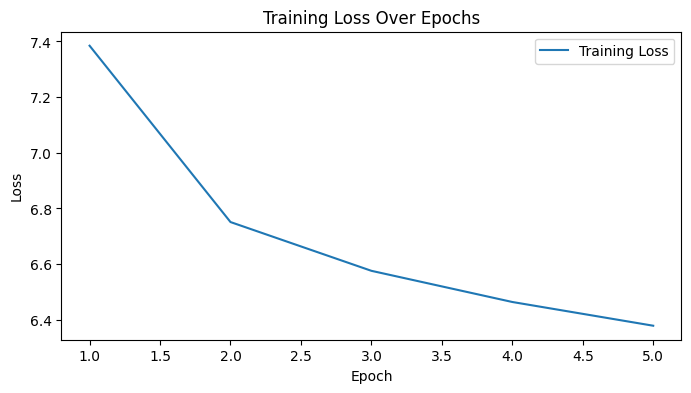

Starting Epoch 6/10
Epoch 6, Batch 100, Loss: 6.1244
Epoch 6, Batch 200, Loss: 6.4583
Epoch 6, Batch 300, Loss: 6.5097
Epoch 6, Batch 400, Loss: 6.3146
Epoch 6, Batch 500, Loss: 6.0390
Epoch 6/10, Avg Loss: 6.3165


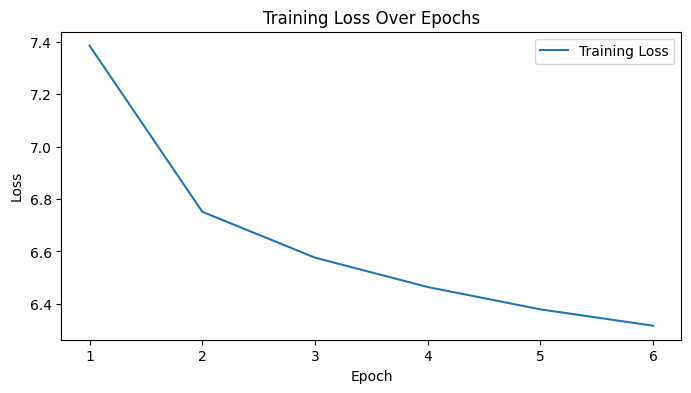

Starting Epoch 7/10
Epoch 7, Batch 100, Loss: 6.2573
Epoch 7, Batch 200, Loss: 6.2665
Epoch 7, Batch 300, Loss: 6.1655
Epoch 7, Batch 400, Loss: 6.0914
Epoch 7, Batch 500, Loss: 6.2553
Epoch 7/10, Avg Loss: 6.2590


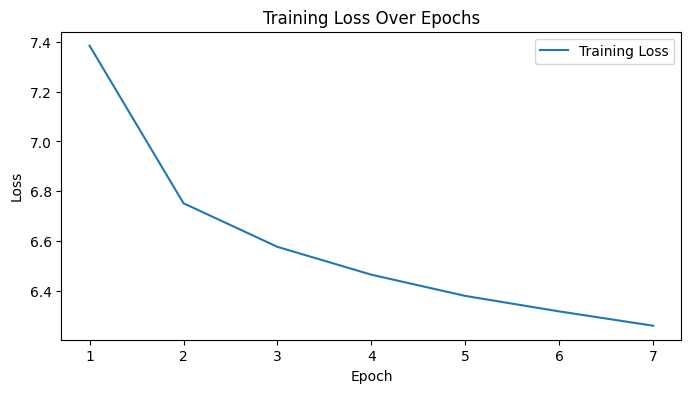

Starting Epoch 8/10
Epoch 8, Batch 100, Loss: 6.3390
Epoch 8, Batch 200, Loss: 6.1222
Epoch 8, Batch 300, Loss: 6.2841
Epoch 8, Batch 400, Loss: 6.1192
Epoch 8, Batch 500, Loss: 6.0652
Epoch 8/10, Avg Loss: 6.2200


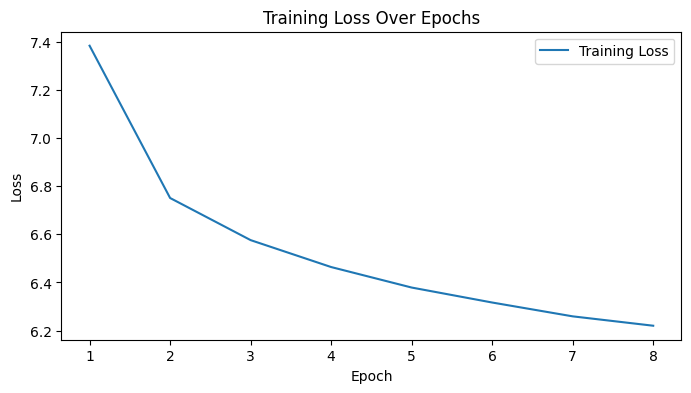

Starting Epoch 9/10
Epoch 9, Batch 100, Loss: 6.1882
Epoch 9, Batch 200, Loss: 6.1748
Epoch 9, Batch 300, Loss: 5.9565
Epoch 9, Batch 400, Loss: 6.0545
Epoch 9, Batch 500, Loss: 6.1092
Epoch 9/10, Avg Loss: 6.1754


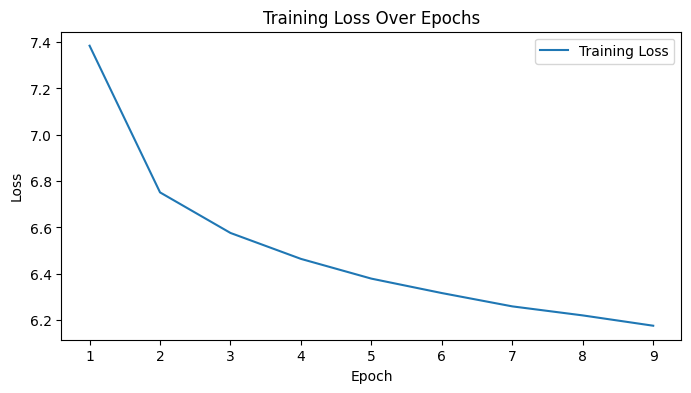

Starting Epoch 10/10
Epoch 10, Batch 100, Loss: 6.0432
Epoch 10, Batch 200, Loss: 6.1090
Epoch 10, Batch 300, Loss: 6.1910
Epoch 10, Batch 400, Loss: 6.1007
Epoch 10, Batch 500, Loss: 6.2759
Epoch 10/10, Avg Loss: 6.1448


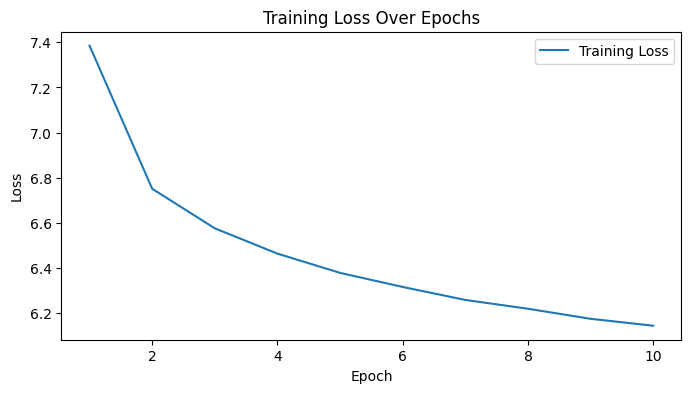

In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Ensure the TransformerModel class and tokenizer are already defined and loaded
# from your previous cells.

# Define hyperparameters and instantiate the model
vocab_size = tokenizer.get_vocab_size()  # Tokenizer is now defined
d_model = 256
num_heads = 8
num_layers = 6
seq_length = 512

model = TransformerModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    seq_length=seq_length
)

# Check if GPU is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display model details
print(f"Model instantiated on device: {device}")

# Use the existing persian_dataloader for training
train_dataloader = persian_dataloader  # This DataLoader returns sequences of 512 tokens

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
train_losses = []
max_batches_per_epoch = 500  # Limit to 500 batches per epoch to reduce runtime

for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        if batch_idx >= max_batches_per_epoch:
            break  # Exit after processing max_batches_per_epoch

        batch = batch.to(device)  # batch shape: (batch_size, seq_length)
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch)  # logits shape: (batch_size, seq_length, vocab_size)

        # Calculate loss (shifted targets)
        target = batch[:, 1:].contiguous()  # shape: (batch_size, seq_length - 1)

        # Reshape logits and target for loss computation
        logits_reshaped = logits[:, :-1, :].reshape(-1, vocab_size)  # shape: (batch_size * (seq_length -1), vocab_size)
        target_reshaped = target.reshape(-1)  # shape: (batch_size * (seq_length -1))

        loss = criterion(logits_reshaped, target_reshaped)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Optional: Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / max_batches_per_epoch
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    # Plot loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epoch+2), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()


| Parameter               | Value                  | Description                                                                                          |
|-------------------------|------------------------|------------------------------------------------------------------------------------------------------|
| `device`                | `cuda` or `cpu`        | The device on which the model is run. Using GPU (`cuda`) can significantly speed up training.         |
| `raw_text`              | Content of `"Persian-WikiText-1.txt"` | The raw Persian text data loaded from the specified file for model training.                         |
| `persian_tokenizer`     | Loaded from `"trained_bpe_tokenizer.json"` | The pre-trained Byte-Pair Encoding (BPE) tokenizer used to convert text into token IDs.              |
| `tokenized_ids`         | List of token IDs      | The entire Persian text converted into a list of numerical token IDs using the tokenizer.            |
| `MAX_DATA_SIZE`         | `10000`                | Limits the dataset to the first 10,000 tokens for faster experimentation and reduced computational load. |
| `window_size`           | `512`                  | The length of each input sequence fed into the Transformer model, corresponding to `seq_length`.      |
| `sequence_length`       | `512`                  | The fixed length of each sequence used for training, matching the model's expected input size.       |
| `batch_size`            | `8`                    | The number of sequences processed in each training batch. Smaller batches require less memory.        |
| `vocab_size`            | Number of unique tokens| The size of the vocabulary, determined by the tokenizer, defining the embedding and output layers.    |
| `d_model`               | `256`                  | The dimensionality of the token embeddings and the Transformer model's internal representations.     |
| `num_heads`             | `8`                    | The number of attention heads in each Transformer encoder layer, allowing the model to focus on different parts of the input. |
| `num_layers`            | `6`                    | The number of stacked Transformer encoder layers, increasing the model's capacity to learn complex patterns. |
| `seq_length`            | `512`                  | The maximum sequence length for positional encoding, matching the input sequence length.             |
| `lr` (learning rate)    | `1e-4`                 | The learning rate for the `Adam` optimizer, controlling the step size during weight updates.         |
| `criterion`             | `CrossEntropyLoss`     | The loss function used to compute the difference between the predicted logits and the target tokens.  |
| `optimizer`             | `Adam` with `lr=1e-4`  | The optimizer used for updating the model's weights based on the computed gradients.                  |
| `epochs`                | `10`                   | The number of complete passes through the training dataset.                                          |
| `max_batches_per_epoch` | `500`                  | Limits the number of batches processed per epoch to reduce runtime during training.                  |
| `train_losses`          | List of floats         | A history of average loss values recorded at the end of each epoch for monitoring training progress. |


## Perplexity

In [ ]:
from torch.utils.data import random_split

# Define the validation split ratio
validation_split = 0.1
total_size = len(persian_dataset)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(persian_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")


In [22]:
# Define the perplexity calculation function
def calculate_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)  # Shape: (batch_size, seq_length)
            
            # Forward pass
            logits = model(batch)  # Shape: (batch_size, seq_length, vocab_size)
            
            # Prepare targets by shifting the input by one token
            target = batch[:, 1:].contiguous()  # Shape: (batch_size, seq_length - 1)
            
            # Reshape logits and target for loss computation
            logits = logits[:, :-1, :].reshape(-1, logits.size(-1))  # Shape: (batch_size * (seq_length -1), vocab_size)
            target = target.reshape(-1)  # Shape: (batch_size * (seq_length -1))
            
            # Compute loss
            loss = criterion(logits, target)
            total_loss += loss.item() * target.size(0)
            total_tokens += target.size(0)
    
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity

# Calculate perplexity on the validation set
perplexity = calculate_perplexity(model, val_dataloader, criterion, device)
print(f"Validation Perplexity: {perplexity:.4f}")

Validation Perplexity: 444.6799


# Inference

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0, device='cuda'):
    """
    Generate text using the trained Transformer model.

    Args:
        model (nn.Module): Trained Transformer model.
        tokenizer (Tokenizer): Pre-trained tokenizer.
        prompt (str): The initial text to start generating from.
        max_length (int): Number of tokens to generate.
        temperature (float): Sampling temperature. Higher values increase diversity.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        str: Generated text.
    """
    # Encode the prompt
    input_ids = tokenizer.encode(prompt).ids
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    generated = input_ids.copy()

    for _ in range(max_length):
        # Ensure the input does not exceed the model's sequence length
        if len(generated) > seq_length:
            input_tensor = torch.tensor([generated[-seq_length:]], dtype=torch.long).to(device)
        else:
            input_tensor = torch.tensor([generated], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(input_tensor)  # Shape: (1, seq_length, vocab_size) or (1, len(generated), vocab_size)
            logits = logits[:, -1, :]  # Get logits for the last token
            logits = logits / temperature
            probabilities = torch.softmax(logits, dim=-1)

            # Sample the next token
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()

        # Append the generated token
        generated.append(next_token_id)

    # Decode the generated tokens back to text
    generated_text = tokenizer.decode(generated)
    return generated_text

In [21]:
# Example prompt in Persian
prompt = "یادگیری عمیق یک زیرشاخه مهم از یادگیری ماشین است که"

# Generate text
generated_sample = generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_length=50,      # Number of tokens to generate
    temperature=0.8,    # Adjust temperature for diversity
    device=device
)

print("Generated Text:")
print(generated_sample)

Generated Text:
یادگیری عمیق یک زیرشاخه مهم از یادگیری ماشین است که های تیسفون در هنگام ورود به همه بسیار مشروط به کشور ایران می شود . از توابع بخش دیگری صندوق اصلی آن را در سال ۱۳۰۸ را بیشتر ، به خانه . فسفات با ایران در سراسر این فیلسوف رمز های جدید محسوب می شود . در اواخر قرن اخیر


# **Comparison  RNN and Transformer Models**

## **Training Loss and Perplexity**
1. **RNN Model**:
   - **Loss**: The training loss decreased steadily from `9.2620` to `4.0678` over 10 epochs.
   - **Perplexity**: Achieved a very low validation perplexity of `2.0727`, indicating a strong ability to predict the validation data.

2. **Transformer Model**:
   - **Loss**: Training loss decreased steadily from approximately `7.4` to `6.2` (as shown in the uploaded loss curve) over 10 epochs.
   - **Perplexity**: The validation perplexity is much higher at `444.6799`, indicating poorer generalization and predictive power compared to the RNN.

## **Generated Text Quality**
1. **RNN Model**:
   - The generated text is repetitive and gets stuck in a loop (`...از آن ها به کار های ویکی پدیا...`), suggesting limited ability to generate coherent long sequences.
   - It performs well for short spans but fails to maintain meaningful and diverse content for longer outputs.

2. **Transformer Model**:
   - The generated text is more diverse and syntactically coherent. However, it lacks semantic consistency and contains unrelated or nonsensical phrases (`...فسفات با ایران در سراسر این فیلسوف رمز های جدید...`).
   - The higher capacity of the Transformer allows it to produce more varied output, but the lack of sufficient training or data quality may have hindered performance.

## **Model Architecture and Performance**
1. **RNN**:
   - **Strengths**: 
     - Simpler architecture; performs better with small datasets.
     - Captures sequential dependencies effectively in smaller-scale tasks.
     - Achieved lower perplexity, indicating better modeling of the dataset.
   - **Weaknesses**:
     - Struggles with long-term dependencies due to vanishing gradients.
     - Limited generation diversity and prone to repetitive text.

2. **Transformer**:
   - **Strengths**:
     - Handles long-range dependencies better through self-attention.
     - Generates more diverse and complex text structures.
   - **Weaknesses**:
     - Higher computational requirements.
     - Requires a larger dataset to generalize effectively, which might have contributed to the high perplexity.

## **Conclusions**
1. The **RNN model** is more effective for this dataset, achieving a much lower perplexity and stable training loss. However, its generation quality is limited due to repetitiveness.
2. The **Transformer model**, while more advanced, underperforms due to its inability to generalize effectively with the current dataset. The high perplexity suggests either insufficient data, suboptimal hyperparameters, or limited training epochs.
3. For this task, the RNN is more suitable due to its ability to generalize better with the dataset provided. The Transformer may outperform with better tuning and more training data.
